In [1]:
import pandas as pd
import numpy as np
from scipy import stats as sp
import sys, os
sys.path.append('../')
import trace_analysis
import plots_analysis
import trace_statistics
import trace_classification
import csv
from lib.functions import *
import warnings 
warnings.filterwarnings('ignore')

# Data Preparation


Prepare the data to be used with kNN

In [2]:
plots = set()
with open('traces/traces.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0 or row[2].find('normal') >= 0:
            line_count += 1
            continue
        else:
            plots.add((row[1], row[2]))

plots = list(plots)            

stats = None
win_25_stats = None
win_50_stats = None
win_100_stats = None

for row in plots:
    experiment = row[1]
    
    # Assign a label
    if row[1].find('gh') >= 0:
        label = 'GH'
    else:
        label = 'BH'
    nodes, packets_node = trace_analysis.process_cooja2_traces(row[0], row[1])
    
    # Update stats
    if stats is None:
        stats = trace_statistics.compute_labeled_statistics(nodes, packets_node, label, experiment)
        win_25_stats = trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 25)
        win_50_stats = trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 50)
        win_100_stats = trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 100)
    else:
        stats = pd.concat([stats, trace_statistics.compute_labeled_statistics(nodes, packets_node, label, experiment)])
        win_25_stats = pd.concat([win_25_stats, trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 25)])
        win_50_stats = pd.concat([win_50_stats, trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 50)])
        win_100_stats = pd.concat([win_100_stats, trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 100)])
        
stats = stats.reset_index(drop=True)
win_25_stats = win_25_stats.reset_index(drop=True)
win_50_stats = win_50_stats.reset_index(drop=True)
win_100_stats = win_100_stats.reset_index(drop=True)

# Create a dictionary containing all the statistics for each trace size
trace_stats = {200: stats, 25: win_25_stats, 50: win_50_stats, 100: win_100_stats}
stats.head(5)

,node_id,experiment,count,mean,var,std,hop,min,max,loss,outliers,label
0,aaaa::212:7404:4:404:,rnd_1bh-2_2019-02-14_15:38_,199,118.358291,2223.949716,47.158771,2,67.2,446.0,0.005,10,BH
1,aaaa::212:7405:5:505:,rnd_1bh-2_2019-02-14_15:38_,162,147.724074,7966.380721,89.254584,2,72.5,673.0,0.190,7,BH
2,aaaa::212:7409:9:909:,rnd_1bh-2_2019-02-14_15:38_,200,58.024500,1382.140352,37.177148,1,28.3,448.0,0.000,5,BH
3,aaaa::212:740a:a:a0a:,rnd_1bh-2_2019-02-14_15:38_,172,121.721512,3900.118891,62.450932,2,68.1,549.0,0.140,7,BH
4,aaaa::212:7402:2:202:,rnd_1bh-2_2019-02-14_15:38_,172,133.307558,4593.581989,67.775969,2,71.9,489.0,0.140,6,BH


Split topologies

In [3]:
rnd1 = []
rnd2 = []
plot = []
for trace in plots:
    if trace[0].find('rnd-1') >= 0:
        rnd1.append(trace)
    elif trace[0].find('rnd-2') >= 0:
        rnd2.append(trace)
    else:
        plot.append(trace)
        

        
plot_stats = None
plot_win_25_stats = None
plot_win_50_stats = None
plot_win_100_stats = None
for row in plot:
    experiment = row[1]
    
    # Assign a label
    if row[1].find('gh') >= 0:
        label = 'GH'
    else:
        label = 'BH'
    nodes, packets_node = trace_analysis.process_cooja2_traces(row[0], row[1])
    
    # Update stats
    if stats is None:
        plot_stats = trace_statistics.compute_labeled_statistics(nodes, packets_node, label, experiment)
        plot_win_25_stats = trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 25)
        win_50_stats = trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 50)
        plot_win_100_stats = trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 100)
    else:
        plot_stats = pd.concat([plot_stats, trace_statistics.compute_labeled_statistics(nodes, packets_node, label, experiment)])
        plot_win_25_stats = pd.concat([plot_win_25_stats, trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 25)])
        plot_win_50_stats = pd.concat([plot_win_50_stats, trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 50)])
        plot_win_100_stats = pd.concat([plot_win_100_stats, trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 100)])
        
plot_stats = plot_stats.reset_index(drop=True)
plot_win_25_stats = plot_win_25_stats.reset_index(drop=True)
plot_win_50_stats = plot_win_50_stats.reset_index(drop=True)
plot_win_100_stats = plot_win_100_stats.reset_index(drop=True)

# Create a dictionary containing all the statistics for each trace size
plot_trace_stats = {200: plot_stats, 25: plot_win_25_stats, 50: plot_win_50_stats, 100: plot_win_100_stats}
plot_stats.head(5)

,node_id,experiment,count,mean,var,std,hop,min,max,loss,outliers,label
0,aaaa::212:7408:8:808:,grid_1gh-6_2019-02-15_18:25_,192,186.145833,2110.816318,45.943621,4,126.0,494.0,0.040,10,GH
1,aaaa::212:7403:3:303:,grid_1gh-6_2019-02-15_18:25_,189,53.622222,1064.422163,32.625483,1,24.6,221.0,0.055,7,GH
2,aaaa::212:7409:9:909:,grid_1gh-6_2019-02-15_18:25_,100,164.013000,5896.618314,76.789441,3,96.3,443.0,0.500,6,GH
3,aaaa::212:740a:a:a0a:,grid_1gh-6_2019-02-15_18:25_,186,175.919355,4753.285353,68.944074,4,111.0,495.0,0.070,11,GH
4,aaaa::212:7402:2:202:,grid_1gh-6_2019-02-15_18:25_,198,101.321212,1990.757822,44.617909,2,52.2,344.0,0.010,10,GH


In [4]:
rnd1_stats = None
rnd1_win_25_stats = None
rnd1_win_50_stats = None
rnd1_win_100_stats = None
for row in rnd1:
    experiment = row[1]
    
    # Assign a label
    if row[1].find('gh') >= 0:
        label = 'GH'
    else:
        label = 'BH'
    nodes, packets_node = trace_analysis.process_cooja2_traces(row[0], row[1])
    
    # Update stats
    if stats is None:
        rnd1_stats = trace_statistics.compute_labeled_statistics(nodes, packets_node, label, experiment)
        rnd1_win_25_stats = trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 25)
        rnd1_win_50_stats = trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 50)
        rnd1_win_100_stats = trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 100)
    else:
        rnd1_stats = pd.concat([rnd1_stats, trace_statistics.compute_labeled_statistics(nodes, packets_node, label, experiment)])
        rnd1_win_25_stats = pd.concat([rnd1_win_25_stats, trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 25)])
        rnd1_win_50_stats = pd.concat([rnd1_win_50_stats, trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 50)])
        rnd1_win_100_stats = pd.concat([rnd1_win_100_stats, trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 100)])
        
rnd1_stats = rnd1_stats.reset_index(drop=True)
rnd1_win_25_stats = rnd1_win_25_stats.reset_index(drop=True)
rnd1_win_50_stats = rnd1_win_50_stats.reset_index(drop=True)
rnd1_win_100_stats = rnd1_win_100_stats.reset_index(drop=True)

# Create a dictionary containing all the statistics for each trace size
rnd1_trace_stats = {200: rnd1_stats, 25: rnd1_win_25_stats, 50: rnd1_win_50_stats, 100: rnd1_win_100_stats}
rnd1_stats.head(5)

,node_id,experiment,count,mean,var,std,hop,min,max,loss,outliers,label
0,aaaa::212:7404:4:404:,rnd_1bh-2_2019-02-14_15:38_,199,118.358291,2223.949716,47.158771,2,67.2,446.0,0.005,10,BH
1,aaaa::212:7405:5:505:,rnd_1bh-2_2019-02-14_15:38_,162,147.724074,7966.380721,89.254584,2,72.5,673.0,0.190,7,BH
2,aaaa::212:7409:9:909:,rnd_1bh-2_2019-02-14_15:38_,200,58.024500,1382.140352,37.177148,1,28.3,448.0,0.000,5,BH
3,aaaa::212:740a:a:a0a:,rnd_1bh-2_2019-02-14_15:38_,172,121.721512,3900.118891,62.450932,2,68.1,549.0,0.140,7,BH
4,aaaa::212:7402:2:202:,rnd_1bh-2_2019-02-14_15:38_,172,133.307558,4593.581989,67.775969,2,71.9,489.0,0.140,6,BH


In [5]:
rnd2_stats = None
rnd2_win_25_stats = None
rnd2_win_50_stats = None
rnd2_win_100_stats = None
for row in rnd2:
    experiment = row[1]
    
    # Assign a label
    if row[1].find('gh') >= 0:
        label = 'GH'
    else:
        label = 'BH'
    nodes, packets_node = trace_analysis.process_cooja2_traces(row[0], row[1])
    
    # Update stats
    if stats is None:
        rnd2_stats = trace_statistics.compute_labeled_statistics(nodes, packets_node, label, experiment)
        rnd2_win_25_stats = trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 25)
        rnd2_win_50_stats = trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 50)
        rnd2_win_100_stats = trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 100)
    else:
        rnd2_stats = pd.concat([rnd2_stats, trace_statistics.compute_labeled_statistics(nodes, packets_node, label, experiment)])
        rnd2_win_25_stats = pd.concat([rnd2_win_25_stats, trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 25)])
        rnd2_win_50_stats = pd.concat([rnd2_win_50_stats, trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 50)])
        rnd2_win_100_stats = pd.concat([rnd2_win_100_stats, trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 100)])
        
rnd2_stats = rnd2_stats.reset_index(drop=True)
rnd2_win_25_stats = rnd2_win_25_stats.reset_index(drop=True)
rnd2_win_50_stats = rnd2_win_50_stats.reset_index(drop=True)
rnd2_win_100_stats = rnd2_win_100_stats.reset_index(drop=True)

# Create a dictionary containing all the statistics for each trace size
rnd2_trace_stats = {200: rnd2_stats, 25: rnd2_win_25_stats, 50: rnd2_win_50_stats, 100: rnd2_win_100_stats}
rnd2_stats.head(5)

,node_id,experiment,count,mean,var,std,hop,min,max,loss,outliers,label
0,aaaa::212:7407:7:707:,rnd2_1bh-6_2019-02-15_16:56_,147,99.755102,1423.423176,37.728281,2,56.8,287.0,0.265,6,BH
1,aaaa::212:7406:6:606:,rnd2_1bh-6_2019-02-15_16:56_,175,55.374857,320.942698,17.914874,1,30.6,136.0,0.125,9,BH
2,aaaa::212:7409:9:909:,rnd2_1bh-6_2019-02-15_16:56_,192,121.103125,1181.226796,34.368980,3,87.1,395.0,0.040,7,BH
3,aaaa::212:7402:2:202:,rnd2_1bh-6_2019-02-15_16:56_,171,45.773099,220.967037,14.864960,1,25.2,145.0,0.145,8,BH
4,aaaa::212:740a:a:a0a:,rnd2_1bh-6_2019-02-15_16:56_,171,109.670175,2019.538576,44.939277,2,67.8,445.0,0.145,5,BH


Stats for single network

In [6]:
net_stats = trace_statistics.compute_labeled_statistics_by_network(stats, 'loss', 9)
net_win_25_stats = trace_statistics.compute_window_labeled_statistics_by_network(win_25_stats, 'loss', 9, 25)
net_win_50_stats = trace_statistics.compute_window_labeled_statistics_by_network(win_50_stats, 'loss', 9, 50)
net_win_100_stats = trace_statistics.compute_window_labeled_statistics_by_network(win_100_stats, 'loss', 9, 100)

# Create a dictionary containing all the statistics for each trace size
network_stats = {200: net_stats, 25: net_win_25_stats, 50: net_win_50_stats, 100: net_win_100_stats}
net_stats.head(5)

,experiment,label,1,2,3,4,5,6,7,8,9
0,grid9_1bh-3_2019-02-13_16:28_,BH,0.070,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18
1,grid9_1bh-3_2019-02-13_22:05_,BH,0.045,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18
2,grid9_1bh-5_2019-02-13_15:31_,BH,0.190,4.000000e-02,1.450000e-01,7.500000e-02,2.000000e-02,2.450000e-01,8.500000e-02,9.500000e-02,1.900000e-01
3,grid9_1bh-5_2019-02-13_21:44_,BH,0.020,7.500000e-02,9.000000e-02,1.750000e-01,2.100000e-01,3.000000e-02,1.350000e-01,1.600000e-01,1.150000e-01
4,grid9_1bh-6_2019-02-13_12:59_,BH,0.040,2.050000e-01,1.000000e-01,1.650000e-01,1.650000e-01,1.000000e-02,8.000000e-02,1.550000e-01,9.223372e+18


In [7]:
plot_net_stats = trace_statistics.compute_labeled_statistics_by_network(plot_stats, 'loss', 9)
plot_net_win_25_stats = trace_statistics.compute_window_labeled_statistics_by_network(plot_win_25_stats, 'loss', 9, 25)
plot_net_win_50_stats = trace_statistics.compute_window_labeled_statistics_by_network(plot_win_50_stats, 'loss', 9, 50)
plot_net_win_100_stats = trace_statistics.compute_window_labeled_statistics_by_network(plot_win_100_stats, 'loss', 9, 100)

# Create a dictionary containing all the statistics for each trace size
plot_network_stats = {200: plot_net_stats, 25: plot_net_win_25_stats, 50: plot_net_win_50_stats, 100: plot_net_win_100_stats}
plot_net_stats.head(5)

,experiment,label,1,2,3,4,5,6,7,8,9
0,grid9_1bh-3_2019-02-13_16:28_,BH,0.070,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18
1,grid9_1bh-3_2019-02-13_22:05_,BH,0.045,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18
2,grid9_1bh-5_2019-02-13_15:31_,BH,0.040,1.450000e-01,7.500000e-02,1.900000e-01,2.000000e-02,2.450000e-01,1.900000e-01,8.500000e-02,9.500000e-02
3,grid9_1bh-5_2019-02-13_21:44_,BH,0.115,1.600000e-01,2.000000e-02,7.500000e-02,9.000000e-02,1.750000e-01,2.100000e-01,3.000000e-02,1.350000e-01
4,grid9_1bh-6_2019-02-13_12:59_,BH,0.205,1.000000e-02,8.000000e-02,1.550000e-01,4.000000e-02,1.000000e-01,1.650000e-01,1.650000e-01,9.223372e+18


In [8]:
rnd1_net_stats = trace_statistics.compute_labeled_statistics_by_network(rnd1_stats, 'loss', 9)
rnd1_net_win_25_stats = trace_statistics.compute_window_labeled_statistics_by_network(rnd1_win_25_stats, 'loss', 9, 25)
rnd1_net_win_50_stats = trace_statistics.compute_window_labeled_statistics_by_network(rnd1_win_50_stats, 'loss', 9, 50)
rnd1_net_win_100_stats = trace_statistics.compute_window_labeled_statistics_by_network(rnd1_win_100_stats, 'loss', 9, 100)

# Create a dictionary containing all the statistics for each trace size
rnd1_network_stats = {200: rnd1_net_stats, 25: rnd1_net_win_25_stats, 50: rnd1_net_win_50_stats, 100: rnd1_net_win_100_stats}
rnd1_net_stats.head(5)

,experiment,label,1,2,3,4,5,6,7,8,9
0,rnd_1bh-2_2019-02-14_15:38_,BH,0.005,0.190,0.000000e+00,1.400000e-01,1.400000e-01,5.000000e-03,1.500000e-01,1.500000e-02,9.223372e+18
1,rnd_1bh-7_2019-02-14_13:57_,BH,0.030,0.045,2.500000e-02,1.150000e-01,1.000000e-02,0.000000e+00,1.500000e-02,1.550000e-01,3.500000e-02
2,rnd_1bh-9_2019-02-14_15:15_,BH,0.075,0.045,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18
3,rnd_1gh-2_2019-02-16_08:37_,GH,0.010,0.015,0.000000e+00,5.200000e-01,5.000000e-03,7.500000e-02,1.000000e-02,1.400000e-01,8.500000e-02
4,rnd_1gh-7_2019-02-16_10:16_,GH,0.010,0.005,4.000000e-02,1.500000e-02,1.500000e-01,1.500000e-01,3.000000e-02,6.500000e-02,2.500000e-02


In [9]:
rnd2_net_stats = trace_statistics.compute_labeled_statistics_by_network(rnd2_stats, 'loss', 9)
rnd2_net_win_25_stats = trace_statistics.compute_window_labeled_statistics_by_network(rnd2_win_25_stats, 'loss', 9, 25)
rnd2_net_win_50_stats = trace_statistics.compute_window_labeled_statistics_by_network(rnd2_win_50_stats, 'loss', 9, 50)
rnd2_net_win_100_stats = trace_statistics.compute_window_labeled_statistics_by_network(rnd2_win_100_stats, 'loss', 9, 100)

# Create a dictionary containing all the statistics for each trace size
rnd2_network_stats = {200: rnd2_net_stats, 25: rnd2_net_win_25_stats, 50: rnd2_net_win_50_stats, 100: rnd2_net_win_100_stats}
rnd2_net_stats.head(5)

,experiment,label,1,2,3,4,5,6,7,8,9
0,rnd-2_1gh-3_2019-02-16_11:41_,GH,0.645,0.145,0.165,0.030,0.550,0.045,0.035,4.500000e-02,1.800000e-01
1,rnd2_1bh-3_2019-02-14_17:02_,BH,0.015,0.075,0.080,0.025,0.110,0.045,0.055,9.223372e+18,9.223372e+18
2,rnd2_1bh-6_2019-02-15_16:56_,BH,0.265,0.055,0.170,0.275,0.145,0.145,0.040,1.250000e-01,9.223372e+18
3,rnd2_1bh-8_2019-02-15_17:28_,BH,0.020,0.045,0.080,0.035,0.015,0.020,0.075,2.000000e-02,1.000000e-02


# Feature Selection

Select the set of features and labels that we use to fit the algorithm

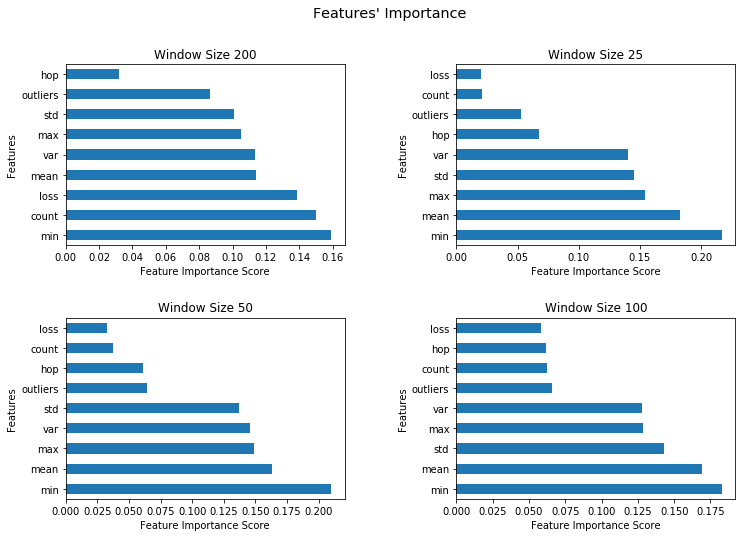

In [10]:
plots_analysis.random_forests_features_selection(trace_stats)

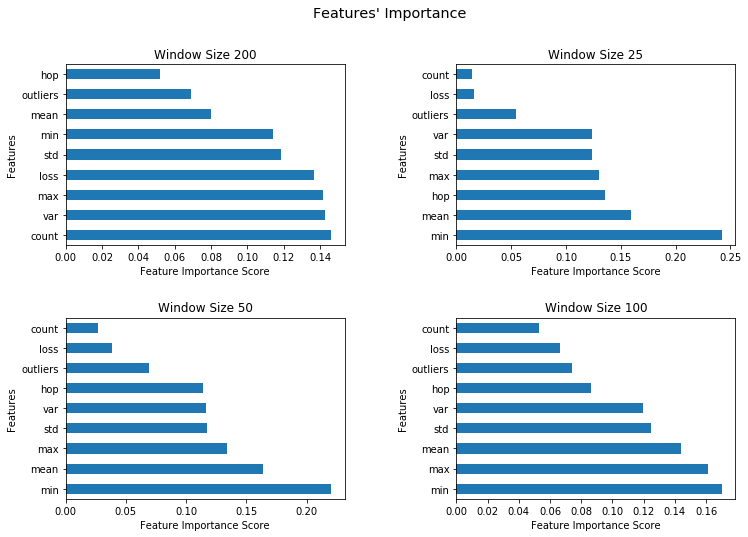

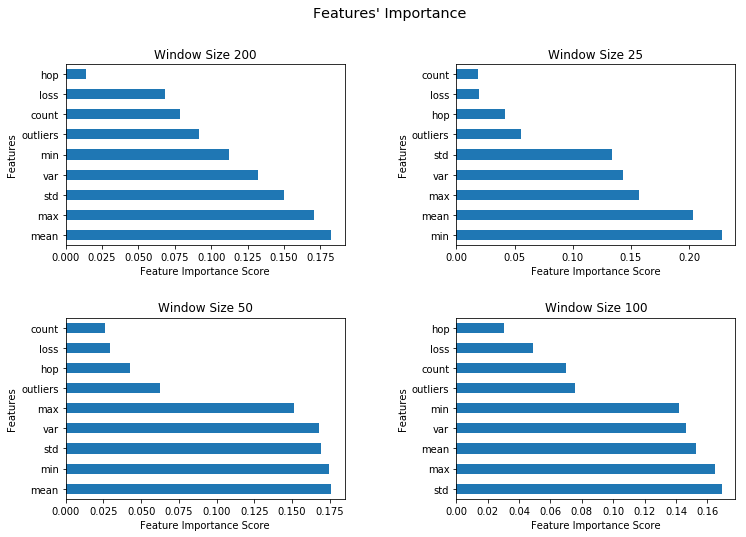

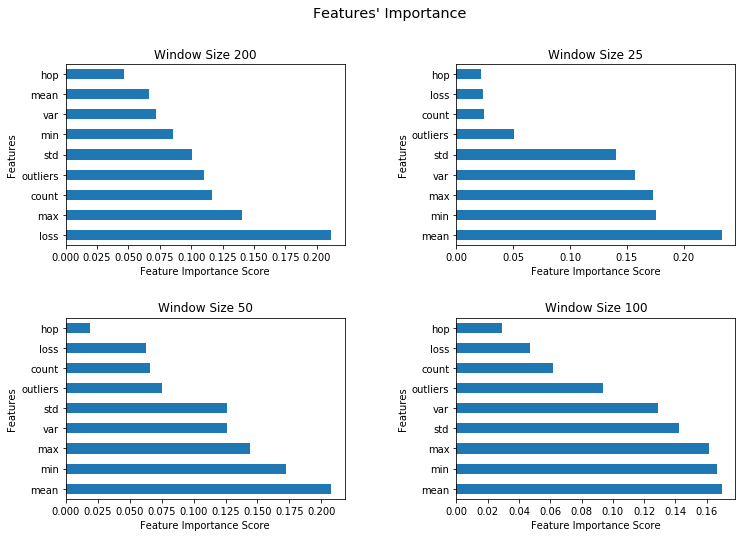

In [11]:
plots_analysis.random_forests_features_selection(plot_trace_stats)
plots_analysis.random_forests_features_selection(rnd1_trace_stats)
plots_analysis.random_forests_features_selection(rnd2_trace_stats)

In [12]:
results = None            # Results from each classification algorithm
cv_results = None         # Cross validation results from each classification algorithm
net_results = None            # Results from each classification algorithm
cv_net_results = None         # Cross validation results from each classification algorithm

features_to_drop = ['node_id', 'experiment', 'label', 'hop', 'loss', 'count', 'outliers']
net_features_to_drop = ['experiment', 'label']

In [13]:
plot_results = None            # Results from each classification algorithm
plot_cv_results = None         # Cross validation results from each classification algorithm
plot_net_results = None            # Results from each classification algorithm
plot_cv_net_results = None         # Cross validation results from each classification algorithm

rnd1_results = None            # Results from each classification algorithm
rnd1_cv_results = None         # Cross validation results from each classification algorithm
rnd1_net_results = None            # Results from each classification algorithm
rnd1_cv_net_results = None         # Cross validation results from each classification algorithm

rnd2_results = None            # Results from each classification algorithm
rnd2_cv_results = None         # Cross validation results from each classification algorithm
rnd2_net_results = None            # Results from each classification algorithm
rnd2_cv_net_results = None         # Cross validation results from each classification algorithm

# Random Forests Classifier

Let us experiment with random forests. First, let us select most relevant features.

In [14]:
results = pd.concat([results, 
                     trace_classification.random_forest_classification(trace_stats, features_to_drop)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


In [15]:
plot_results = pd.concat([plot_results, 
                     trace_classification.random_forest_classification(plot_trace_stats, features_to_drop)
                    ])
rnd1_results = pd.concat([rnd1_results, 
                     trace_classification.random_forest_classification(rnd1_trace_stats, features_to_drop)
                    ])
rnd2_results = pd.concat([rnd2_results, 
                     trace_classification.random_forest_classification(rnd2_trace_stats, features_to_drop)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100
Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100
Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


We want to compute average accuracy for each trace size (i.e. for each window size from 200 - the entire window - to 100, 50 and 25)

In [16]:
cv_results = pd.concat([cv_results, 
                     trace_classification.random_forest_cross_validation(trace_stats, features_to_drop)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


In [17]:
plot_cv_results = pd.concat([plot_cv_results, 
                     trace_classification.random_forest_cross_validation(plot_trace_stats, features_to_drop)
                    ])

rnd1_cv_results = pd.concat([rnd1_cv_results, 
                     trace_classification.random_forest_cross_validation(rnd1_trace_stats, features_to_drop)
                    ])

rnd2_cv_results = pd.concat([rnd2_cv_results, 
                     trace_classification.random_forest_cross_validation(rnd2_trace_stats, features_to_drop)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100
Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100
Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Let's do the same for the whole network

In [18]:
net_results = pd.concat([net_results, 
                     trace_classification.random_forest_classification(network_stats, net_features_to_drop)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


In [19]:
plot_net_results = pd.concat([plot_net_results, 
                     trace_classification.random_forest_classification(plot_network_stats, net_features_to_drop)
                    ])

rnd1_net_results = pd.concat([rnd1_net_results, 
                     trace_classification.random_forest_classification(rnd1_network_stats, net_features_to_drop)
                    ])

rnd2_net_results = pd.concat([rnd2_net_results, 
                     trace_classification.random_forest_classification(rnd2_network_stats, net_features_to_drop)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100
Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100
Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Cross validation

In [20]:
cv_net_results = pd.concat([cv_net_results, 
                     trace_classification.random_forest_cross_validation(network_stats, net_features_to_drop, cross_val=3)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


In [21]:
plot_cv_net_results = pd.concat([plot_cv_net_results, 
                     trace_classification.random_forest_cross_validation(plot_network_stats, net_features_to_drop, cross_val=3)
                    ])

rnd1_cv_net_results = pd.concat([rnd1_cv_net_results, 
                     trace_classification.random_forest_cross_validation(rnd1_network_stats, net_features_to_drop, cross_val=3)
                    ])

rnd2_cv_net_results = pd.concat([rnd2_cv_net_results, 
                     trace_classification.random_forest_cross_validation(rnd2_network_stats, net_features_to_drop, cross_val=3)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100
Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100
Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


# K-Nearest Neighbor (KNN) Classification

Let us first observe the accuracies for different values of k

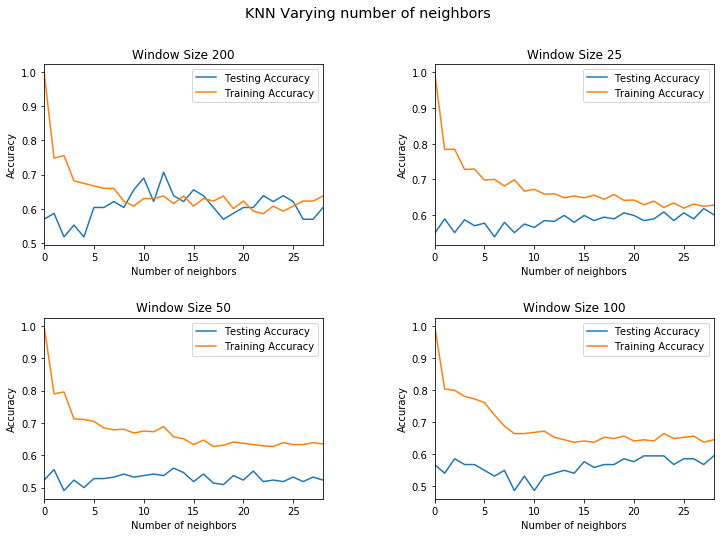

In [22]:
plots_analysis.knn_test_number_of_neighbors(trace_stats, 30)

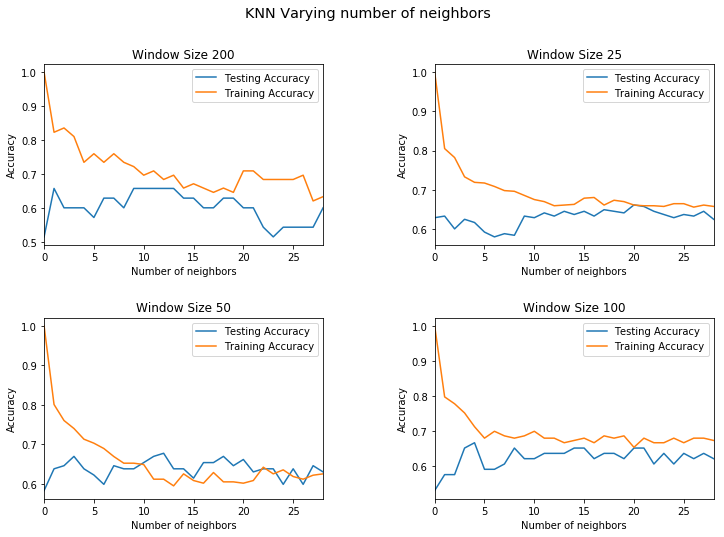

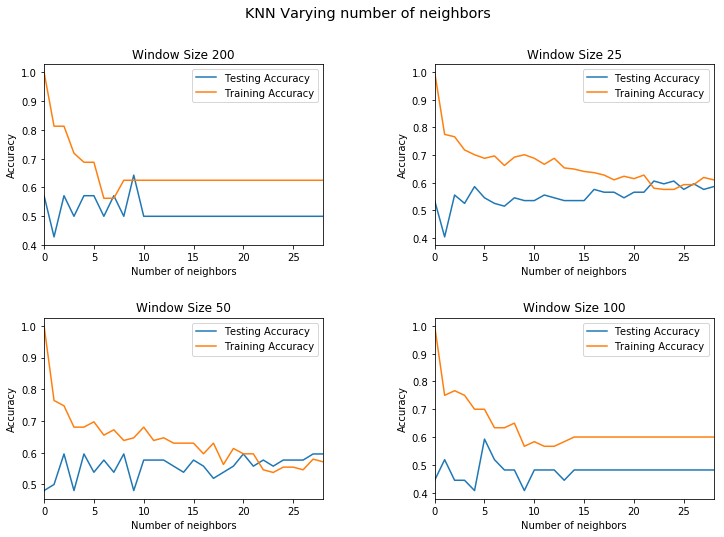

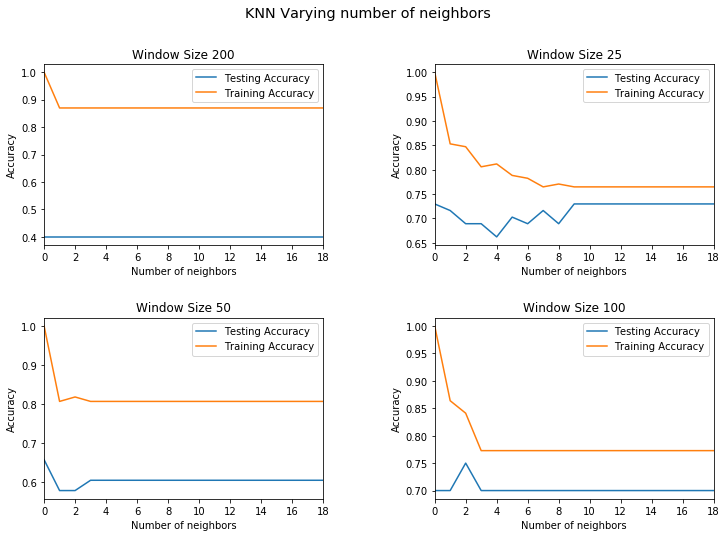

In [23]:
plots_analysis.knn_test_number_of_neighbors(plot_trace_stats, 30)
plots_analysis.knn_test_number_of_neighbors(rnd1_trace_stats, 30)
plots_analysis.knn_test_number_of_neighbors(rnd2_trace_stats, 20)

Let's build KNN classifier 

In [24]:
results = pd.concat([results, 
                     trace_classification.k_nearest_neighbor_classification(trace_stats, features_to_drop, n_neighbors=30)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


In [25]:
plot_results = pd.concat([plot_results, 
                     trace_classification.k_nearest_neighbor_classification(plot_trace_stats, features_to_drop, n_neighbors=8)
                    ])

rnd1_results = pd.concat([rnd1_results, 
                     trace_classification.k_nearest_neighbor_classification(rnd1_trace_stats, features_to_drop, n_neighbors=7)
                    ])

rnd2_results = pd.concat([rnd2_results, 
                     trace_classification.k_nearest_neighbor_classification(rnd2_trace_stats, features_to_drop, n_neighbors=7)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100
Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100
Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


We want to compute average accuracy for each trace size (i.e. for each window size from 200 - the entire window - to 100, 50 and 25)

In [26]:
cv_results = pd.concat([cv_results, 
                     trace_classification.k_nearest_neighbor_cross_validation(trace_stats, features_to_drop, n_neighbors=30)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


In [27]:
plot_cv_results = pd.concat([plot_cv_results, 
                     trace_classification.k_nearest_neighbor_cross_validation(plot_trace_stats, features_to_drop, n_neighbors=8)
                    ])

rnd1_cv_results = pd.concat([rnd1_cv_results, 
                     trace_classification.k_nearest_neighbor_cross_validation(rnd1_trace_stats, features_to_drop, n_neighbors=7)
                    ])

rnd2_cv_results = pd.concat([rnd2_cv_results, 
                     trace_classification.k_nearest_neighbor_cross_validation(rnd2_trace_stats, features_to_drop, n_neighbors=7)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100
Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100
Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Let's do the same for the whole network

In [28]:
net_results = pd.concat([net_results, 
                     trace_classification.k_nearest_neighbor_classification(network_stats, net_features_to_drop)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


In [29]:
plot_net_results = pd.concat([plot_net_results, 
                     trace_classification.k_nearest_neighbor_classification(plot_network_stats, net_features_to_drop)
                    ])

rnd1_net_results = pd.concat([rnd1_net_results, 
                     trace_classification.k_nearest_neighbor_classification(rnd1_network_stats, net_features_to_drop)
                    ])

rnd2_net_results = pd.concat([rnd2_net_results, 
                     trace_classification.k_nearest_neighbor_classification(rnd2_network_stats, net_features_to_drop, n_neighbors = 2)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100
Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100
Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Cross validation

In [30]:
cv_net_results = pd.concat([cv_net_results, 
                     trace_classification.k_nearest_neighbor_cross_validation(network_stats, net_features_to_drop, cross_val=3)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


In [31]:
plot_cv_net_results = pd.concat([plot_cv_net_results, 
                     trace_classification.k_nearest_neighbor_cross_validation(plot_network_stats, net_features_to_drop, cross_val=3)
                    ])

rnd1_cv_net_results = pd.concat([rnd1_cv_net_results, 
                     trace_classification.k_nearest_neighbor_cross_validation(rnd1_network_stats, net_features_to_drop, cross_val=3)
                    ])

rnd2_cv_net_results = pd.concat([rnd2_cv_net_results, 
                     trace_classification.k_nearest_neighbor_cross_validation(rnd2_network_stats, net_features_to_drop, cross_val=3, n_neighbors = 2)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100
Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100
Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


# Support Vector Machines (SVM) Classification

Let us experiment with another classifier

In [32]:
results = pd.concat([results, 
                     trace_classification.support_vector_machines_classification(trace_stats, features_to_drop, kernel='rbf')
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


In [33]:
plot_results = pd.concat([plot_results, 
                     trace_classification.support_vector_machines_classification(plot_trace_stats, features_to_drop, kernel='rbf')
                    ])

rnd1_results = pd.concat([rnd1_results, 
                     trace_classification.support_vector_machines_classification(rnd1_trace_stats, features_to_drop, kernel='rbf')
                    ])

rnd2_results = pd.concat([rnd2_results, 
                     trace_classification.support_vector_machines_classification(rnd2_trace_stats, features_to_drop, kernel='rbf')
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100
Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100
Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


We want to compute average accuracy for each trace size (i.e. for each window size from 200 - the entire window - to 100, 50 and 25)

In [34]:
cv_results = pd.concat([cv_results, 
                     trace_classification.support_vector_machines_cross_validation(trace_stats, features_to_drop, kernel='rbf')
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


In [35]:
plot_cv_results = pd.concat([plot_cv_results, 
                     trace_classification.support_vector_machines_cross_validation(plot_trace_stats, features_to_drop, kernel='rbf')
                    ])

rnd1_cv_results = pd.concat([rnd1_cv_results, 
                     trace_classification.support_vector_machines_cross_validation(rnd1_trace_stats, features_to_drop, kernel='rbf')
                    ])

rnd2_cv_results = pd.concat([rnd2_cv_results, 
                     trace_classification.support_vector_machines_cross_validation(rnd2_trace_stats, features_to_drop, kernel='rbf')
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100
Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100
Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Let's do the same for the whole network

In [36]:
net_results = pd.concat([net_results, 
                     trace_classification.support_vector_machines_classification(network_stats, net_features_to_drop, kernel='rbf')
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


In [37]:
plot_net_results = pd.concat([plot_net_results, 
                     trace_classification.support_vector_machines_classification(plot_network_stats, net_features_to_drop, kernel='rbf')
                    ])

rnd1_net_results = pd.concat([rnd1_net_results, 
                     trace_classification.support_vector_machines_classification(rnd1_network_stats, net_features_to_drop, kernel='rbf')
                    ])

rnd2_net_results = pd.concat([rnd2_net_results, 
                     trace_classification.support_vector_machines_classification(rnd2_network_stats, net_features_to_drop, kernel='rbf')
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100
Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100
Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Cross validation

In [38]:
cv_net_results = pd.concat([cv_net_results, 
                     trace_classification.support_vector_machines_cross_validation(network_stats, net_features_to_drop, cross_val=3)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


In [39]:
plot_cv_net_results = pd.concat([plot_cv_net_results, 
                     trace_classification.support_vector_machines_cross_validation(plot_network_stats, net_features_to_drop, cross_val=3)
                    ])

rnd1_cv_net_results = pd.concat([rnd1_cv_net_results, 
                     trace_classification.support_vector_machines_cross_validation(rnd1_network_stats, net_features_to_drop, cross_val=3)
                    ])

'''rnd2_cv_net_results = pd.concat([rnd2_cv_net_results, 
                     trace_classification.support_vector_machines_cross_validation(rnd2_network_stats, net_features_to_drop, cross_val=3)
                    ])'''

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100
Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


'rnd2_cv_net_results = pd.concat([rnd2_cv_net_results, \n                     trace_classification.support_vector_machines_cross_validation(rnd2_network_stats, net_features_to_drop, cross_val=3)\n                    ])'

# One Vs The Rest Classifier

SVM performs really well, but it is slow. Now we try to implement it in a most efficient way. The strategy consists in fitting one classifier per class. For each classifier, the class is fitted against all the other classes

In [40]:
results = pd.concat([results, 
                     trace_classification.ensalble_svm_classification(trace_stats, features_to_drop, n_estimators=10)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


In [41]:
plot_results = pd.concat([plot_results, 
                     trace_classification.ensalble_svm_classification(plot_trace_stats, features_to_drop, n_estimators=15)
                    ])

rnd1_results = pd.concat([rnd1_results, 
                     trace_classification.ensalble_svm_classification(rnd1_trace_stats, features_to_drop, n_estimators=15)
                    ])

rnd2_results = pd.concat([rnd2_results, 
                     trace_classification.ensalble_svm_classification(rnd2_trace_stats, features_to_drop, n_estimators=15)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100
Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100
Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Cross validate

In [42]:
cv_results = pd.concat([cv_results, 
                     trace_classification.ensalble_svm_cross_validation(trace_stats, features_to_drop, n_estimators=15)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


In [43]:
plot_cv_results = pd.concat([plot_cv_results, 
                     trace_classification.ensalble_svm_cross_validation(plot_trace_stats, features_to_drop, n_estimators=15)
                    ])

rnd1_cv_results = pd.concat([rnd1_cv_results, 
                     trace_classification.ensalble_svm_cross_validation(rnd1_trace_stats, features_to_drop, n_estimators=15)
                    ])

rnd2_cv_results = pd.concat([rnd2_cv_results, 
                     trace_classification.ensalble_svm_cross_validation(rnd2_trace_stats, features_to_drop, n_estimators=15)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100
Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100
Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Let's do the same for the whole network

In [44]:
net_results = pd.concat([net_results, 
                     trace_classification.ensalble_svm_classification(network_stats, net_features_to_drop)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


In [45]:
plot_net_results = pd.concat([plot_net_results, 
                     trace_classification.ensalble_svm_classification(plot_network_stats, net_features_to_drop)
                    ])

'''rnd1_net_results = pd.concat([rnd1_net_results, 
                     trace_classification.ensalble_svm_classification(rnd1_network_stats, net_features_to_drop)
                    ])

rnd2_net_results = pd.concat([rnd2_net_results, 
                     trace_classification.ensalble_svm_classification(rnd2_network_stats, net_features_to_drop)
                    ])'''

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


'rnd1_net_results = pd.concat([rnd1_net_results, \n                     trace_classification.ensalble_svm_classification(rnd1_network_stats, net_features_to_drop)\n                    ])\n\nrnd2_net_results = pd.concat([rnd2_net_results, \n                     trace_classification.ensalble_svm_classification(rnd2_network_stats, net_features_to_drop)\n                    ])'

Cross validation

In [46]:
cv_net_results = pd.concat([cv_net_results, 
                     trace_classification.ensalble_svm_cross_validation(network_stats, net_features_to_drop, cross_val=3)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


In [47]:
plot_cv_net_results = pd.concat([plot_cv_net_results, 
                     trace_classification.ensalble_svm_cross_validation(plot_network_stats, net_features_to_drop)
                    ])

'''rnd1_cv_net_results = pd.concat([rnd1_cv_net_results, 
                     trace_classification.ensalble_svm_cross_validation(rnd1_network_stats, net_features_to_drop)
                    ])'''


'''rnd2_cv_net_results = pd.concat([rnd2_cv_net_results, 
                     trace_classification.ensalble_svm_cross_validation(rnd2_network_stats, net_features_to_drop)
                    ])'''

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


'rnd2_cv_net_results = pd.concat([rnd2_cv_net_results, \n                     trace_classification.ensalble_svm_cross_validation(rnd2_network_stats, net_features_to_drop)\n                    ])'

# Per Node Results
Results from each model

In [48]:
results.reset_index(drop=True)

,Model,Window Size,Accuracy,Precision,Recall,F1-score,Training Time (sec),Testing Time (sec)
0,Random Forest,200,0.586207,0.567402,0.569444,0.567702,0.071897,0.006831
1,Random Forest,25,0.637890,0.610827,0.607423,0.608641,0.179134,0.011003
2,Random Forest,50,0.560185,0.538450,0.534187,0.529692,0.104504,0.008548
3,Random Forest,100,0.585586,0.567568,0.561503,0.559524,0.076159,0.007161
4,KNN,200,0.603448,0.581988,0.583333,0.582473,0.001069,0.004110
5,KNN,25,0.630695,0.587903,0.536049,0.496976,0.002452,0.012925
6,KNN,50,0.532407,0.453162,0.477735,0.420265,0.001350,0.007220
7,KNN,100,0.594595,0.576098,0.549535,0.526854,0.001077,0.004164
8,SVM,200,0.586207,0.532468,0.525253,0.516667,0.002047,0.001302
9,SVM,25,0.616307,0.551610,0.521987,0.480859,0.021997,0.007136


In [49]:
plot_results.reset_index(drop=True)

,Model,Window Size,Accuracy,Precision,Recall,F1-score,Training Time (sec),Testing Time (sec)
0,Random Forest,200,0.571429,0.541667,0.550000,0.533333,0.069622,0.011497
1,Random Forest,25,0.710204,0.695404,0.685787,0.688981,0.187825,0.014219
2,Random Forest,50,0.692913,0.655280,0.636911,0.641736,0.089868,0.007488
3,Random Forest,100,0.621212,0.533613,0.530435,0.530583,0.065533,0.006750
4,KNN,200,0.628571,0.578671,0.590000,0.579093,0.001001,0.004633
5,KNN,25,0.587755,0.526201,0.514716,0.483672,0.001382,0.007606
6,KNN,50,0.661417,0.605615,0.554080,0.536142,0.001046,0.004603
7,KNN,100,0.606061,0.506250,0.505435,0.503472,0.001047,0.004918
8,SVM,200,0.628571,0.532051,0.530000,0.530444,0.001594,0.001716
9,SVM,25,0.640816,0.634096,0.563898,0.534703,0.008233,0.002671


In [50]:
rnd1_results.reset_index(drop=True)

,Model,Window Size,Accuracy,Precision,Recall,F1-score,Training Time (sec),Testing Time (sec)
0,Random Forest,200,0.357143,0.208333,0.357143,0.263158,0.060057,0.006256
1,Random Forest,25,0.535354,0.536327,0.537712,0.531481,0.074565,0.007458
2,Random Forest,50,0.673077,0.664363,0.662121,0.662981,0.064126,0.006653
3,Random Forest,100,0.555556,0.595238,0.565934,0.523529,0.059633,0.006410
4,KNN,200,0.500000,0.250000,0.500000,0.333333,0.000849,0.001783
5,KNN,25,0.525253,0.516667,0.517161,0.515565,0.000971,0.005337
6,KNN,50,0.557692,0.544547,0.543939,0.544034,0.000900,0.003371
7,KNN,100,0.518519,0.535714,0.527473,0.493506,0.000858,0.002198
8,SVM,200,0.500000,0.250000,0.500000,0.333333,0.001089,0.000612
9,SVM,25,0.575758,0.556514,0.555508,0.555769,0.002124,0.000965


In [51]:
rnd2_results.reset_index(drop=True)

,Model,Window Size,Accuracy,Precision,Recall,F1-score,Training Time (sec),Testing Time (sec)
0,Random Forest,200,0.400000,0.200000,0.500000,0.285714,0.055448,0.006178
1,Random Forest,25,0.675676,0.488636,0.494444,0.471429,0.068210,0.006950
2,Random Forest,50,0.605263,0.302632,0.500000,0.377049,0.060063,0.007689
3,Random Forest,100,0.650000,0.342105,0.464286,0.393939,0.058026,0.006368
4,KNN,200,0.400000,0.200000,0.500000,0.285714,0.000844,0.001567
5,KNN,25,0.689189,0.359155,0.472222,0.408000,0.000933,0.004300
6,KNN,50,0.605263,0.302632,0.500000,0.377049,0.000873,0.002769
7,KNN,100,0.700000,0.350000,0.500000,0.411765,0.000849,0.001926
8,SVM,200,0.400000,0.200000,0.500000,0.285714,0.001471,0.000631
9,SVM,25,0.729730,0.364865,0.500000,0.421875,0.001793,0.000781


Here we plot the average results for each model computed with cross validation

In [52]:
cv_results.reset_index(drop=True)

,Model,Window Size,Mean Accuracy
0,Random Forest,200,0.512551
1,Random Forest,25,0.577114
2,Random Forest,50,0.572099
3,Random Forest,100,0.605496
4,KNN,200,0.526491
5,KNN,25,0.556120
6,KNN,50,0.534724
7,KNN,100,0.588949
8,SVM,200,0.511640
9,SVM,25,0.557580


In [53]:
plot_cv_results.reset_index(drop=True)

,Model,Window Size,Mean Accuracy
0,Random Forest,200,0.612253
1,Random Forest,25,0.657202
2,Random Forest,50,0.676172
3,Random Forest,100,0.621677
4,KNN,200,0.595652
5,KNN,25,0.603123
6,KNN,50,0.586168
7,KNN,100,0.593986
8,SVM,200,0.613439
9,SVM,25,0.619187


In [54]:
rnd1_cv_results.reset_index(drop=True)

,Model,Window Size,Mean Accuracy
0,Random Forest,200,0.569444
1,Random Forest,25,0.524938
2,Random Forest,50,0.561513
3,Random Forest,100,0.561928
4,KNN,200,0.542222
5,KNN,25,0.512764
6,KNN,50,0.585378
7,KNN,100,0.576552
8,SVM,200,0.542778
9,SVM,25,0.542937


In [55]:
rnd2_cv_results.reset_index(drop=True)

,Model,Window Size,Mean Accuracy
0,Random Forest,200,0.588571
1,Random Forest,25,0.631207
2,Random Forest,50,0.605385
3,Random Forest,100,0.654396
4,KNN,200,0.731429
5,KNN,25,0.668112
6,KNN,50,0.675538
7,KNN,100,0.750549
8,SVM,200,0.731429
9,SVM,25,0.745918


# Network Results
Here we print the results from each model on the whole network

In [56]:
net_results.reset_index(drop=True)

,Model,Window Size,Accuracy,Precision,Recall,F1-score,Training Time (sec),Testing Time (sec)
0,Random Forest,200,0.750000,0.857143,0.666667,0.666667,0.069268,0.007002
1,Random Forest,25,0.566667,0.283333,0.500000,0.361702,0.062383,0.006903
2,Random Forest,50,0.566667,0.420000,0.450000,0.422222,0.069675,0.006905
3,Random Forest,100,0.466667,0.269231,0.388889,0.318182,0.061304,0.006892
4,KNN,200,0.875000,0.916667,0.833333,0.854545,0.000918,0.001346
5,KNN,25,0.550000,0.512987,0.507919,0.472485,0.000866,0.002743
6,KNN,50,0.633333,0.327586,0.475000,0.387755,0.000917,0.002809
7,KNN,100,0.400000,0.392857,0.388889,0.389140,0.000806,0.001357
8,SVM,200,0.750000,0.800000,0.800000,0.750000,0.002735,0.000689
9,SVM,25,0.566667,0.283333,0.500000,0.361702,0.001288,0.000776


In [57]:
plot_net_results.reset_index(drop=True)

,Model,Window Size,Accuracy,Precision,Recall,F1-score,Training Time (sec),Testing Time (sec)
0,Random Forest,200,0.400000,0.625000,0.625000,0.400000,0.060859,0.006701
1,Random Forest,25,0.555556,0.277778,0.500000,0.357143,0.076800,0.011885
2,Random Forest,50,0.388889,0.250000,0.318182,0.280000,0.076476,0.006639
3,Random Forest,100,0.555556,0.535714,0.525000,0.500000,0.056207,0.006182
4,KNN,200,0.400000,0.625000,0.625000,0.400000,0.001664,0.001578
5,KNN,25,0.444444,0.333333,0.406250,0.345455,0.001235,0.002037
6,KNN,50,0.555556,0.733333,0.636364,0.532468,0.000846,0.002170
7,KNN,100,0.555556,0.550000,0.550000,0.550000,0.000795,0.001208
8,SVM,200,0.400000,0.625000,0.625000,0.400000,0.001399,0.000767
9,SVM,25,0.555556,0.277778,0.500000,0.357143,0.000930,0.000625


In [58]:
rnd1_net_results.reset_index(drop=True)

,Model,Window Size,Accuracy,Precision,Recall,F1-score,Training Time (sec),Testing Time (sec)
0,Random Forest,200,0.000000,0.000000,0.000000,0.000000,0.055984,0.006154
1,Random Forest,25,0.466667,0.556818,0.550000,0.464286,0.055147,0.006190
2,Random Forest,50,0.250000,0.142857,0.333333,0.200000,0.055985,0.006241
3,Random Forest,100,0.250000,0.250000,0.166667,0.200000,0.055042,0.007570
4,KNN,200,0.000000,0.000000,0.000000,0.000000,0.000763,0.001301
5,KNN,25,0.666667,0.333333,0.500000,0.400000,0.000803,0.001387
6,KNN,50,0.250000,0.142857,0.333333,0.200000,0.000916,0.001304
7,KNN,100,0.250000,0.250000,0.166667,0.200000,0.000835,0.001199
8,SVM,200,0.000000,0.000000,0.000000,0.000000,0.000801,0.000577
9,SVM,25,0.533333,0.708333,0.650000,0.524887,0.000830,0.000592


In [65]:
rnd2_net_results.reset_index(drop=True)

,Model,Window Size,Accuracy,Precision,Recall,F1-score,Training Time (sec),Testing Time (sec)
0,Random Forest,200,0.500000,0.500000,0.250000,0.333333,0.057078,0.006189
1,Random Forest,25,0.800000,0.444444,0.444444,0.444444,0.062933,0.009776
2,Random Forest,50,0.400000,0.250000,0.333333,0.285714,0.054926,0.006494
3,Random Forest,100,0.333333,0.250000,0.250000,0.250000,0.054441,0.006257
4,KNN,200,1.000000,1.000000,1.000000,1.000000,0.000726,0.000988
5,KNN,25,0.800000,0.444444,0.444444,0.444444,0.000798,0.001226
6,KNN,50,0.600000,0.300000,0.500000,0.375000,0.000792,0.001109
7,KNN,100,0.666667,0.333333,0.500000,0.400000,0.000726,0.001014
8,SVM,200,0.000000,0.000000,0.000000,0.000000,0.001087,0.000609
9,SVM,25,0.800000,0.444444,0.444444,0.444444,0.001419,0.000869


Here we plot the average results for each model computed with cross validation

In [60]:
cv_net_results.reset_index(drop=True)

,Model,Window Size,Mean Accuracy
0,Random Forest,200,0.638889
1,Random Forest,25,0.595206
2,Random Forest,50,0.649436
3,Random Forest,100,0.699755
4,KNN,200,0.717593
5,KNN,25,0.585105
6,KNN,50,0.619133
7,KNN,100,0.638480
8,SVM,200,0.717593
9,SVM,25,0.600181


In [61]:
plot_cv_net_results.reset_index(drop=True)

,Model,Window Size,Mean Accuracy
0,Random Forest,200,0.727778
1,Random Forest,25,0.658604
2,Random Forest,50,0.615998
3,Random Forest,100,0.634343
4,KNN,200,0.616667
5,KNN,25,0.675281
6,KNN,50,0.651086
7,KNN,100,0.634343
8,SVM,200,0.588889
9,SVM,25,0.666734


In [62]:
rnd1_cv_net_results.reset_index(drop=True)

,Model,Window Size,Mean Accuracy
0,Random Forest,200,0.666667
1,Random Forest,25,0.541667
2,Random Forest,50,0.500000
3,Random Forest,100,0.333333
4,KNN,200,0.666667
5,KNN,25,0.479167
6,KNN,50,0.458333
7,KNN,100,0.416667
8,SVM,200,0.500000
9,SVM,25,0.500000


In [63]:
rnd2_cv_net_results.reset_index(drop=True)

,Model,Window Size,Mean Accuracy
0,Random Forest,200,0.833333
1,Random Forest,25,0.784848
2,Random Forest,50,0.822222
3,Random Forest,100,0.611111
4,KNN,200,0.833333
5,KNN,25,0.403030
6,KNN,50,0.888889
7,KNN,100,0.777778
